In [2]:
%load_ext autoreload
%autoreload 2

from datetime import date
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors

import os, sys
from glob import glob
import time
from tqdm import tqdm
import torch
import torchvision.transforms as transforms
import pickle
from pathlib import Path

import torch.nn as nn
import torch.nn.functional as F

sys.path.append("../") 
from deepnets import nnModels as models
from deepnets import nnEigenModels as eigModels
from deepnets import nnExperiments as nnexp
from deepnets import nnUtilities as nnutils

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

dataPath = None

Using device: cuda


In [3]:
iterations = 10
fitEvery = np.array([]) #np.array([5,10,20]) # how many iterations to fit over
learningRate = 5e-2
verbose = True

# Prepare Network and Preprocessing
batchSize = 2**9
actFunc = F.relu
pDropout = 0

# Preprocessing for MNIST
preprocess = transforms.Compose([
    transforms.ToTensor(), # first, convert image to PyTorch tensor
    transforms.Normalize((0.1307,), (0.3081,)), # normalize inputs
    transforms.Lambda(torch.flatten), # convert to vectors
])

# Prepare Dataloaders
trainloader, testloader, numClasses = nnutils.downloadMNIST(batchSize=batchSize, preprocess=preprocess)

# Create Network
net = eigModels.eigenNet(trainloader,actFunc=actFunc,pDropout=pDropout) # use testloader for fitting eigenstructure to speed it up...
# net = models.MLP4(actFunc=actFunc,pDropout=pDropout)
net.to(DEVICE)
net.zero_grad()

# Prepare Training Functions 
loss_function = nn.CrossEntropyLoss() # Note: this automatically applies softmax...
# optimizer = torch.optim.SGD(net.parameters(), lr=learningRate)
optimizer = torch.optim.Adadelta(net.parameters())

# Preallocate summary variables  
numTrainingSteps = len(trainloader)*iterations
trackLoss = torch.zeros(numTrainingSteps)
trackAccuracy = torch.zeros(numTrainingSteps)
alignFull = []

# Measuring initial features of network
initWeights = net.getNetworkWeights()
#iEval0,iEvec0,iEval1,iEvec1,iEval2,iEvec2,iEval3,iEvec3 = net.eval0.clone().detach(),net.evec0.clone().detach(),net.eval1.clone().detach(),net.evec1.clone().detach(),net.eval2.clone().detach(),net.evec2.clone().detach(),net.eval3.clone().detach(),net.evec3.clone().detach()

# Train Network & Measure Integration
t = time.time()
for epoch in range(0, iterations): 
    # Set current loss value
    currentLoss = 0.0
    numBatches = 0
    currentCorrect = 0
    currentAttempted = 0
    
    tt = time.time()
    for idx,batch in enumerate(trainloader):
        cidx = epoch*len(trainloader) + idx

        images, label = batch
        images = images.to(DEVICE)
        label = label.to(DEVICE)

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = net(images)

        # Perform backward pass & optimization
        loss = loss_function(outputs, label)
        loss.backward(retain_graph=True)
        optimizer.step()
        
        # Measure Integration
        alignFull.append(net.measureAlignment(images))
        
        # Track Loss and Accuracy
        trackLoss[cidx] = loss.item()
        trackAccuracy[cidx] = 100*torch.sum(torch.argmax(outputs,axis=1)==label)/images.shape[0]
    
    print(f"Time elapsed: {time.time() - tt} seconds")
    
    if np.any(epoch==fitEvery):
        net.fitEigenstructure()
        net.zero_grad()
    
    # Print statistics for each epoch
    if verbose: print('Loss in epoch %3d: %.3f, Accuracy: %.2f%%.' % (epoch, loss.item(), 100*torch.sum(torch.argmax(outputs,axis=1)==label)/images.shape[0]))

# Measure performance on test set
totalLoss = 0
numCorrect = 0
numAttempted = 0
for batch in testloader:
    images, label = batch
    images = images.to(DEVICE)
    label = label.to(DEVICE)
    outputs = net(images)
    totalLoss += loss_function(outputs,label).item()
    output1 = torch.argmax(outputs,axis=1)
    numCorrect += sum(output1==label)
    numAttempted += images.shape[0]
    
print(f"Average loss over test set: %.2f." % (totalLoss / len(testloader)))
print(f"Accuracy over test set: %.2f%%." % (100*numCorrect/numAttempted))
print('Training process has finished in %.3f seconds.' % (time.time()-t))

Running fitEigenstructure...
Time elapsed: 2.8169960975646973 seconds
Loss in epoch   0: 0.969, Accuracy: 67.71%.
Time elapsed: 2.8129971027374268 seconds
Loss in epoch   1: 0.356, Accuracy: 87.50%.
Time elapsed: 2.833995819091797 seconds
Loss in epoch   2: 0.708, Accuracy: 70.83%.
Time elapsed: 2.853996753692627 seconds
Loss in epoch   3: 0.313, Accuracy: 87.50%.


KeyboardInterrupt: 

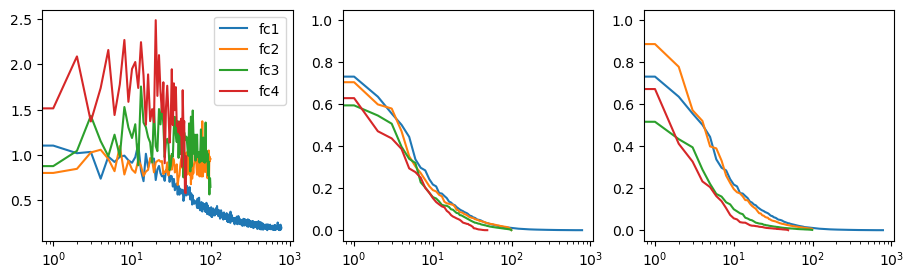

In [8]:
scaleFunc = lambda x : x / x[0] #np.sum(x) * 100

fig,ax = plt.subplots(1,3,figsize=(11,3))
ax[0].plot(scaleFunc(np.mean(np.abs(net.fc1.weight.data.cpu().clone().detach().numpy()),axis=0)),label='fc1')
ax[0].plot(scaleFunc(np.mean(np.abs(net.fc2.weight.data.cpu().clone().detach().numpy()),axis=0)),label='fc2')
ax[0].plot(scaleFunc(np.mean(np.abs(net.fc3.weight.data.cpu().clone().detach().numpy()),axis=0)),label='fc3')
ax[0].plot(scaleFunc(np.mean(np.abs(net.fc4.weight.data.cpu().clone().detach().numpy()),axis=0)),label='fc4')
ax[0].legend();
ax[0].set_xscale('log')

ax[1].plot(scaleFunc(net.eval0.cpu().clone().detach().numpy()))
ax[1].plot(scaleFunc(net.eval1.cpu().clone().detach().numpy()))
ax[1].plot(scaleFunc(net.eval2.cpu().clone().detach().numpy()))
ax[1].plot(scaleFunc(net.eval3.cpu().clone().detach().numpy()))
ax[1].set_xscale('log')

eval0,evec0,eval1,evec1,eval2,evec2,eval3,evec3 = net.getEigenstructure()
ax[2].plot(scaleFunc(eval0.cpu().clone().detach().numpy()))
ax[2].plot(scaleFunc(eval1.cpu().clone().detach().numpy()))
ax[2].plot(scaleFunc(eval2.cpu().clone().detach().numpy()))
ax[2].plot(scaleFunc(eval3.cpu().clone().detach().numpy()))
ax[2].set_xscale('log')

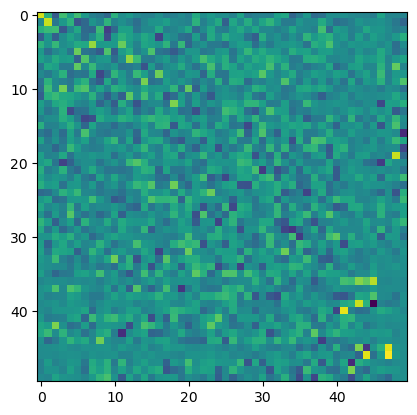

In [20]:
plt.imshow(iEvec3.cpu().T @ evec3.cpu())

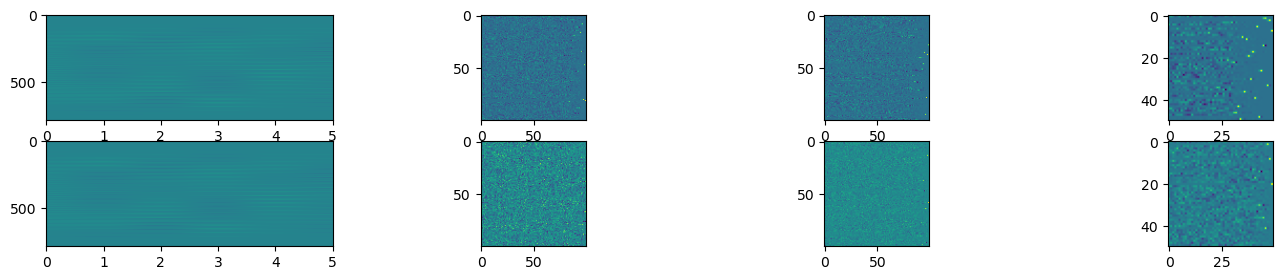

In [9]:
fig,ax = plt.subplots(2,4,figsize=(17,3))
ax[0,0].imshow(net.evec0.cpu().detach().numpy(), aspect='auto')
ax[0,0].set_xlim(0,5)
ax[0,1].imshow(net.evec1.cpu().detach().numpy())
ax[0,2].imshow(net.evec2.cpu().detach().numpy())
ax[0,3].imshow(net.evec3.cpu().detach().numpy())

ax[1,0].imshow(evec0.cpu().detach().numpy(), aspect='auto')
ax[1,0].set_xlim(0,5)
ax[1,1].imshow(evec1.cpu().detach().numpy())
ax[1,2].imshow(evec2.cpu().detach().numpy())
ax[1,3].imshow(evec3.cpu().detach().numpy())

In [ ]:
epoch % fitEvery

0

In [11]:
x = np.random.randint(0,10,(5,3))
print(x)
print(x[:,:,None].transpose(2,0,1))
print(x[None,:,:])

[[4 9 5]
 [5 3 7]
 [3 1 4]
 [2 3 3]
 [0 3 3]]
[[[4 9 5]
  [5 3 7]
  [3 1 4]
  [2 3 3]
  [0 3 3]]]
[[[4 9 5]
  [5 3 7]
  [3 1 4]
  [2 3 3]
  [0 3 3]]]


In [17]:
# Check if I can use autograd to update the eigenvectors by changing data a little bit
N,D = 1000,100
data = torch.normal(0,1,(N,D))
ccov = torch.cov(data.T)
evals,evecs = torch.linalg.eigh(ccov)
ccov.backward()
dgrad = data.grad.data

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [8]:
x = np.random.normal(0,1,10)
w = np.random.normal(0,1,(5,10))
#rq = torch.sum(evals[None,:] * weights**2, dim=1) / torch.sum(weights**2, dim=1)

ss = x[None,:] * w**2
rr = x[None,:] * (w**2)

np.array_equal(ss,rr)

True